In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10


In [2]:
df = pd.read_csv('merged_Floor1.csv', index_col='Date', parse_dates=True)

In [3]:
dataset=pd.DataFrame(columns=['lights','acs','plug'])
dataset

,lights,acs,plug


In [4]:
dataset['lights']=df['z1_Light(kW)']+df['z2_Light(kW)']+df['z3_Light(kW)']+df['z4_Light(kW)']
dataset['acs']=df['z2_AC1(kW)']+df['z2_AC2(kW)']+df['z2_AC3(kW)']+df['z2_AC4(kW)']
dataset['plug']=df['z1_Plug(kW)']+df['z2_Plug(kW)']+df['z3_Plug(kW)']

In [5]:
dataset['Power_consumption']=dataset['lights']+dataset['acs']+dataset['plug']

In [6]:
dataset=dataset.fillna(method="ffill")

In [7]:
dataset=dataset/10000

In [8]:
final_df=dataset

In [9]:
from numpy import array
dataset=np.array(dataset)

In [10]:
n_step=1
lags=7

In [11]:
def to_supervised(train,n_input,n_out):
    #falten data
    data=train
    X,y=list(),list()
    in_start=0
    for _ in range(len(data)):
        in_end=in_start+ n_input
        out_end=in_end + n_out
        if out_end<=len(data):
            x_input=data[ in_start:in_end,0]
            x_input=x_input.reshape((len(x_input)))
            X.append(x_input)
            y.append(data[in_end:out_end,0])
        in_start+=1
    return array(X), array(y) 

In [12]:
X,y=to_supervised(dataset,n_input=lags,n_out=n_step)

In [13]:
from sklearn.model_selection import train_test_split
X_train0, X_test, y_train0, y_test = train_test_split(X, y, random_state=42)
X_train1, X_validation, y_train1, y_validation = train_test_split(X_train0, y_train0, random_state=42)

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [15]:
X_train_s=scaler.fit_transform(X_train1)
X_validation_s=scaler.fit_transform(X_validation)
X_test_s=scaler.fit_transform(X_test)
y_train_s=scaler.fit_transform(y_train1)
y_validation_s=scaler.fit_transform(y_validation)
y_test_s=scaler.fit_transform(y_test)

In [16]:
model_mlp=Sequential()
model_mlp.add(Dense(10,activation="relu",input_dim=X_train_s.shape[1]))
model_mlp.add(Dense(20,activation="relu"))
model_mlp.add(Dense(30,activation="relu"))
model_mlp.add(Dense(n_step,activation="selu"))
model_mlp.compile(loss='mse',optimizer="adam")

In [17]:
history_mlp=model_mlp.fit(X_train_s,y_train_s,epochs=40, validation_data=(X_validation_s,y_validation_s), batch_size=64,verbose=1,shuffle=False)

Epoch 1/40
6949/6949 [==============================] - 12s 2ms/step - loss: 3.1907e-06 - val_loss: 0.0496
Epoch 2/40
6949/6949 [==============================] - 11s 2ms/step - loss: 3.0103e-06 - val_loss: 0.0421
Epoch 3/40
6949/6949 [==============================] - 14s 2ms/step - loss: 2.9577e-06 - val_loss: 0.0404
Epoch 4/40
6949/6949 [==============================] - 16s 2ms/step - loss: 2.8636e-06 - val_loss: 0.0524
Epoch 5/40
6949/6949 [==============================] - 17s 2ms/step - loss: 2.9805e-06 - val_loss: 0.0345
Epoch 6/40
6949/6949 [==============================] - 16s 2ms/step - loss: 2.8698e-06 - val_loss: 0.0427
Epoch 7/40
6949/6949 [==============================] - 17s 2ms/step - loss: 2.8367e-06 - val_loss: 0.0378
Epoch 8/40
6949/6949 [==============================] - 12s 2ms/step - loss: 2.8574e-06 - val_loss: 0.0489
Epoch 9/40
6949/6949 [==============================] - 11s 2ms/step - loss: 2.8012e-06 - val_loss: 0.0459
Epoch 10/40
6949/6949 [==============

In [18]:

y_pred = model_mlp.predict(X_test_s)

6177/6177 [==============================] - 6s 960us/step


In [19]:
y_train_s

array([[0.00659293],
       [0.0277848 ],
       [0.00857249],
       ...,
       [0.0109283 ],
       [0.01961575],
       [0.01401782]])

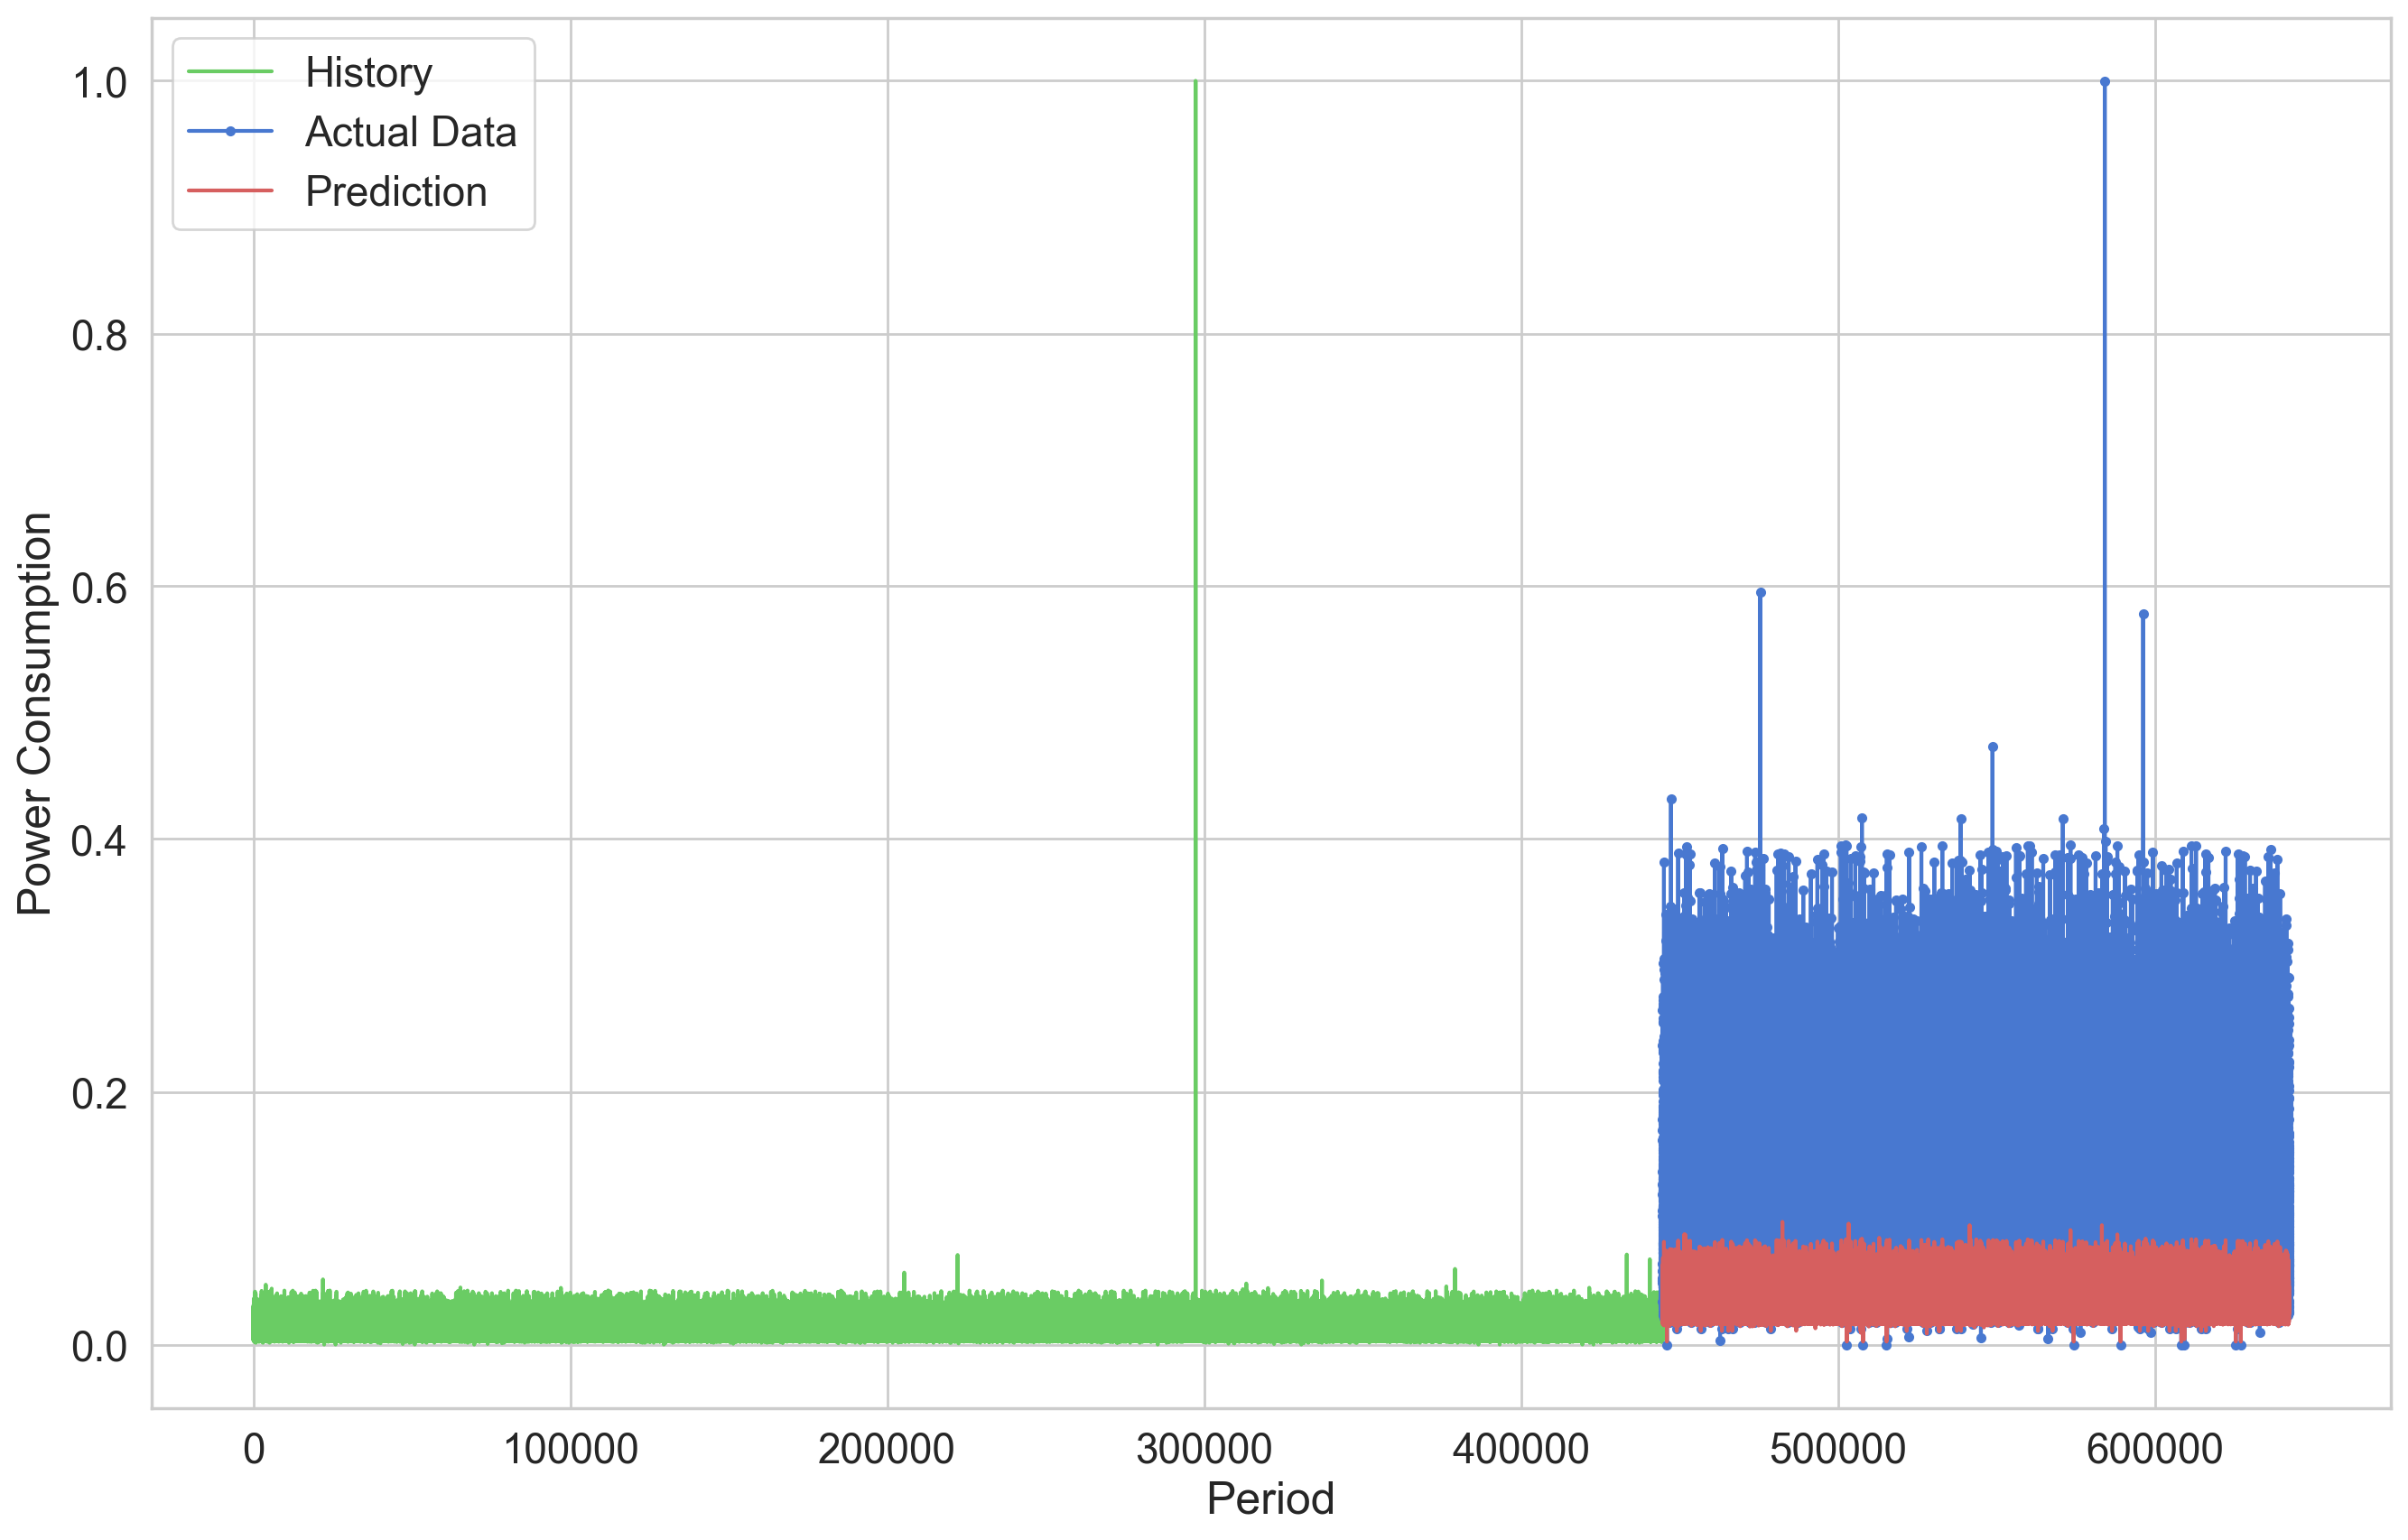

In [20]:

plt.plot(np.arange(0, len(y_train_s)), y_train_s, 'g', label="History")
plt.plot(np.arange(len(y_train_s), len(y_train_s) + len(y_test_s)), y_test_s, marker='.', label="Actual Data")
plt.plot(np.arange(len(y_train_s), len(y_train_s) + len(y_test_s)), y_pred, 'r', label="Prediction")
plt.ylabel('Power Consumption')
plt.xlabel('Period')
plt.legend()
plt.show();

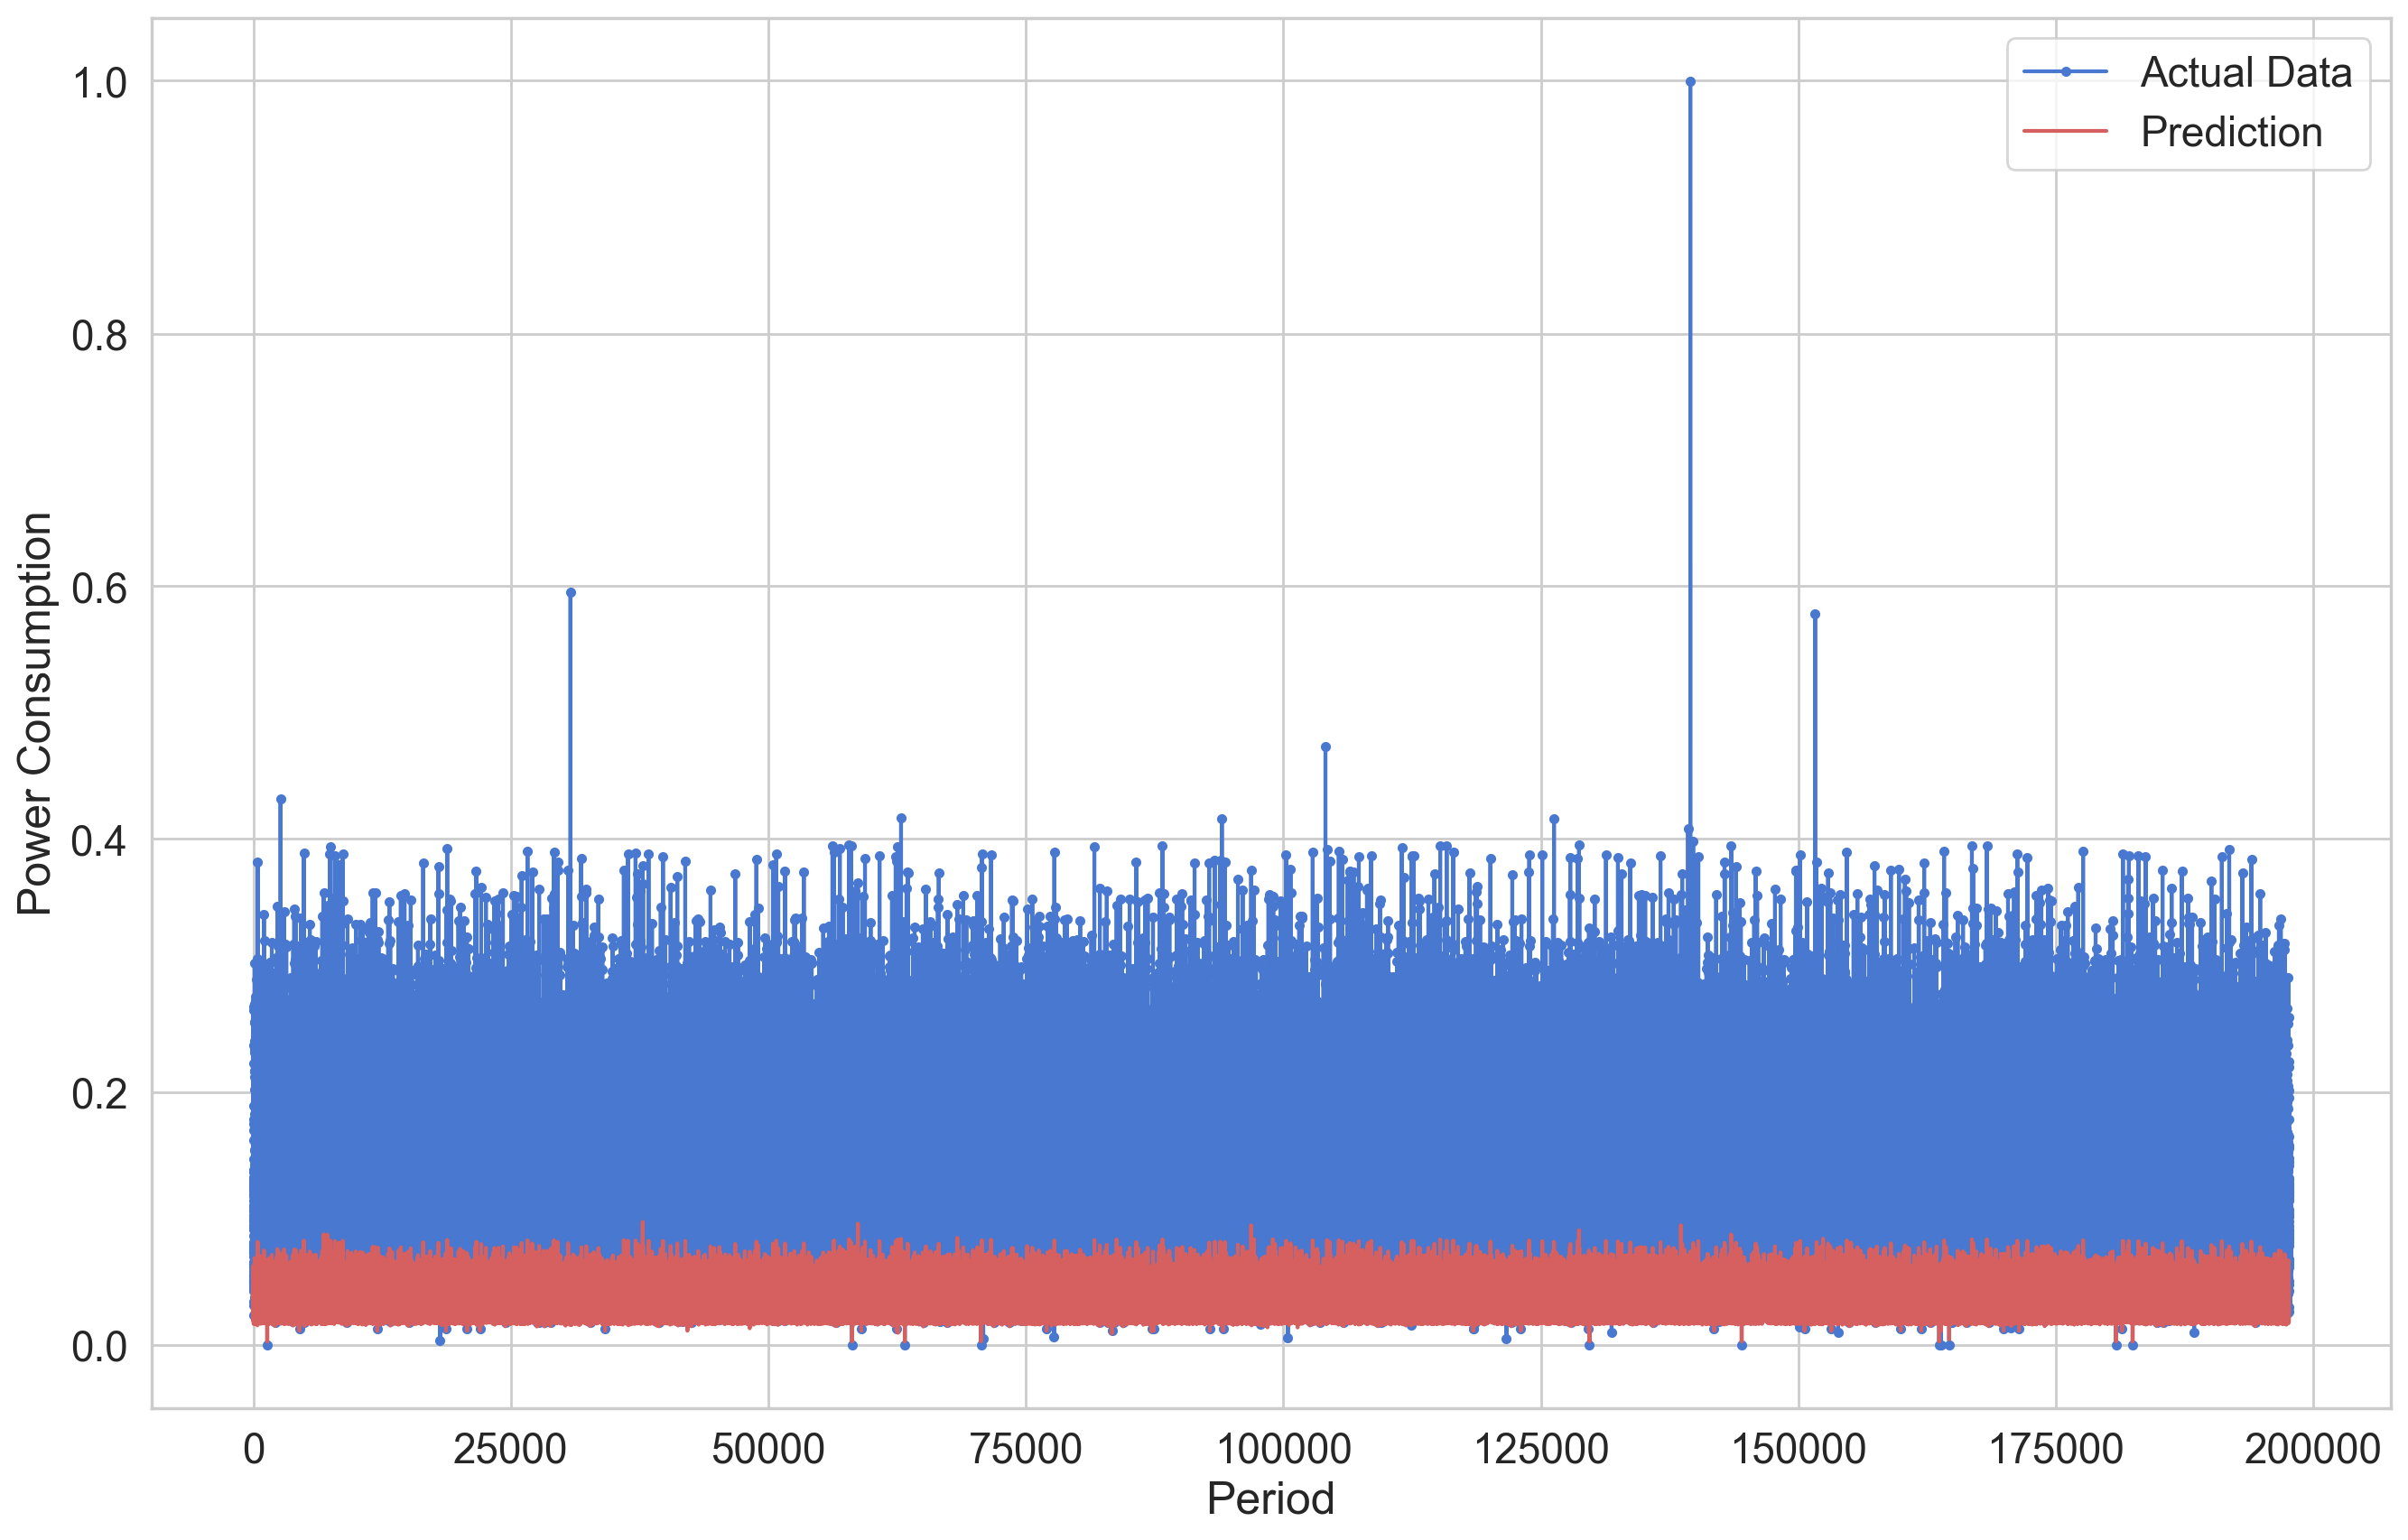

In [21]:
plt.plot(y_test_s, marker='.', label="Actual Data")
plt.plot(y_pred, 'r', label="Prediction")
plt.ylabel('Power Consumption')
plt.xlabel('Period')
plt.legend()
plt.show();
     

In [22]:
import pandas as pd
import numpy as np
mon=final_df.resample('M').mean() #Month wise consideration


In [23]:
mon

,lights,acs,plug,Power_consumption
Date,,,,
2018-07-31,0.006198,0.003835,0.002559,0.012593
2018-08-31,0.006639,0.003783,0.003257,0.015582
2018-09-30,0.005985,0.003322,0.002633,0.013599
2018-10-31,0.006281,0.003133,0.001873,0.011289
2018-11-30,0.006054,0.002883,0.001839,0.010777
2018-12-31,0.005971,0.003288,0.001591,0.010850
2019-01-31,0.005892,0.002755,0.001672,0.010319
2019-02-28,0.005495,0.003417,0.001580,0.010492
2019-03-31,0.004777,0.003369,0.001683,0.009829


In [24]:
from numpy import array
mon=np.array(mon)

In [25]:
X_mon,y_mon=to_supervised(mon,n_input=lags,n_out=n_step)

In [26]:
from sklearn.model_selection import train_test_split
X_train0_mon, X_test_mon, y_train0_mon, y_test_mon = train_test_split(X_mon, y_mon, random_state=42)
X_train1_mon, X_validation_mon, y_train1_mon, y_validation_mon = train_test_split(X_train0_mon, y_train0_mon, random_state=42)

In [27]:
X_train_s_mon=scaler.fit_transform(X_train1_mon)
X_validation_s_mon=scaler.fit_transform(X_validation_mon)
X_test_s_mon=scaler.fit_transform(X_test_mon)
y_train_s_mon=scaler.fit_transform(y_train1_mon)
y_validation_s_mon=scaler.fit_transform(y_validation_mon)
y_test_s_mon=scaler.fit_transform(y_test_mon)

In [28]:
model=Sequential()
model.add(Dense(10,activation="relu",input_dim=X_train_s_mon.shape[1]))
model.add(Dense(20,activation="relu"))
model.add(Dense(30,activation="relu"))
model.add(Dense(n_step,activation="selu"))
model.compile(loss='mse',optimizer="adam")

In [29]:
history_mlp_mon=model.fit(X_train_s_mon,y_train_s_mon,epochs=500, validation_data=(X_validation_s_mon,y_validation_s_mon), batch_size=16,verbose=1,shuffle=False)

Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 0.3780 - val_loss: 1.0834
Epoch 2/500
1/1 [==============================] - 0s 40ms/step - loss: 0.3336 - val_loss: 1.0035
Epoch 3/500
1/1 [==============================] - 0s 53ms/step - loss: 0.2953 - val_loss: 0.9316
Epoch 4/500
1/1 [==============================] - 0s 58ms/step - loss: 0.2624 - val_loss: 0.8669
Epoch 5/500
1/1 [==============================] - 0s 46ms/step - loss: 0.2357 - val_loss: 0.8091
Epoch 6/500
1/1 [==============================] - 0s 29ms/step - loss: 0.2137 - val_loss: 0.7583
Epoch 7/500
1/1 [==============================] - 0s 51ms/step - loss: 0.1958 - val_loss: 0.7142
Epoch 8/500
1/1 [==============================] - 0s 35ms/step - loss: 0.1818 - val_loss: 0.6757
Epoch 9/500
1/1 [==============================] - 0s 38ms/step - loss: 0.1712 - val_loss: 0.6419
Epoch 10/500
1/1 [==============================] - 0s 38ms/step - loss: 0.1633 - val_loss: 0.6123
Epoch 11/500
1/1 [===

In [30]:
y_pred_mon = model.predict(X_test_s_mon)

1/1 [==============================] - 0s 119ms/step


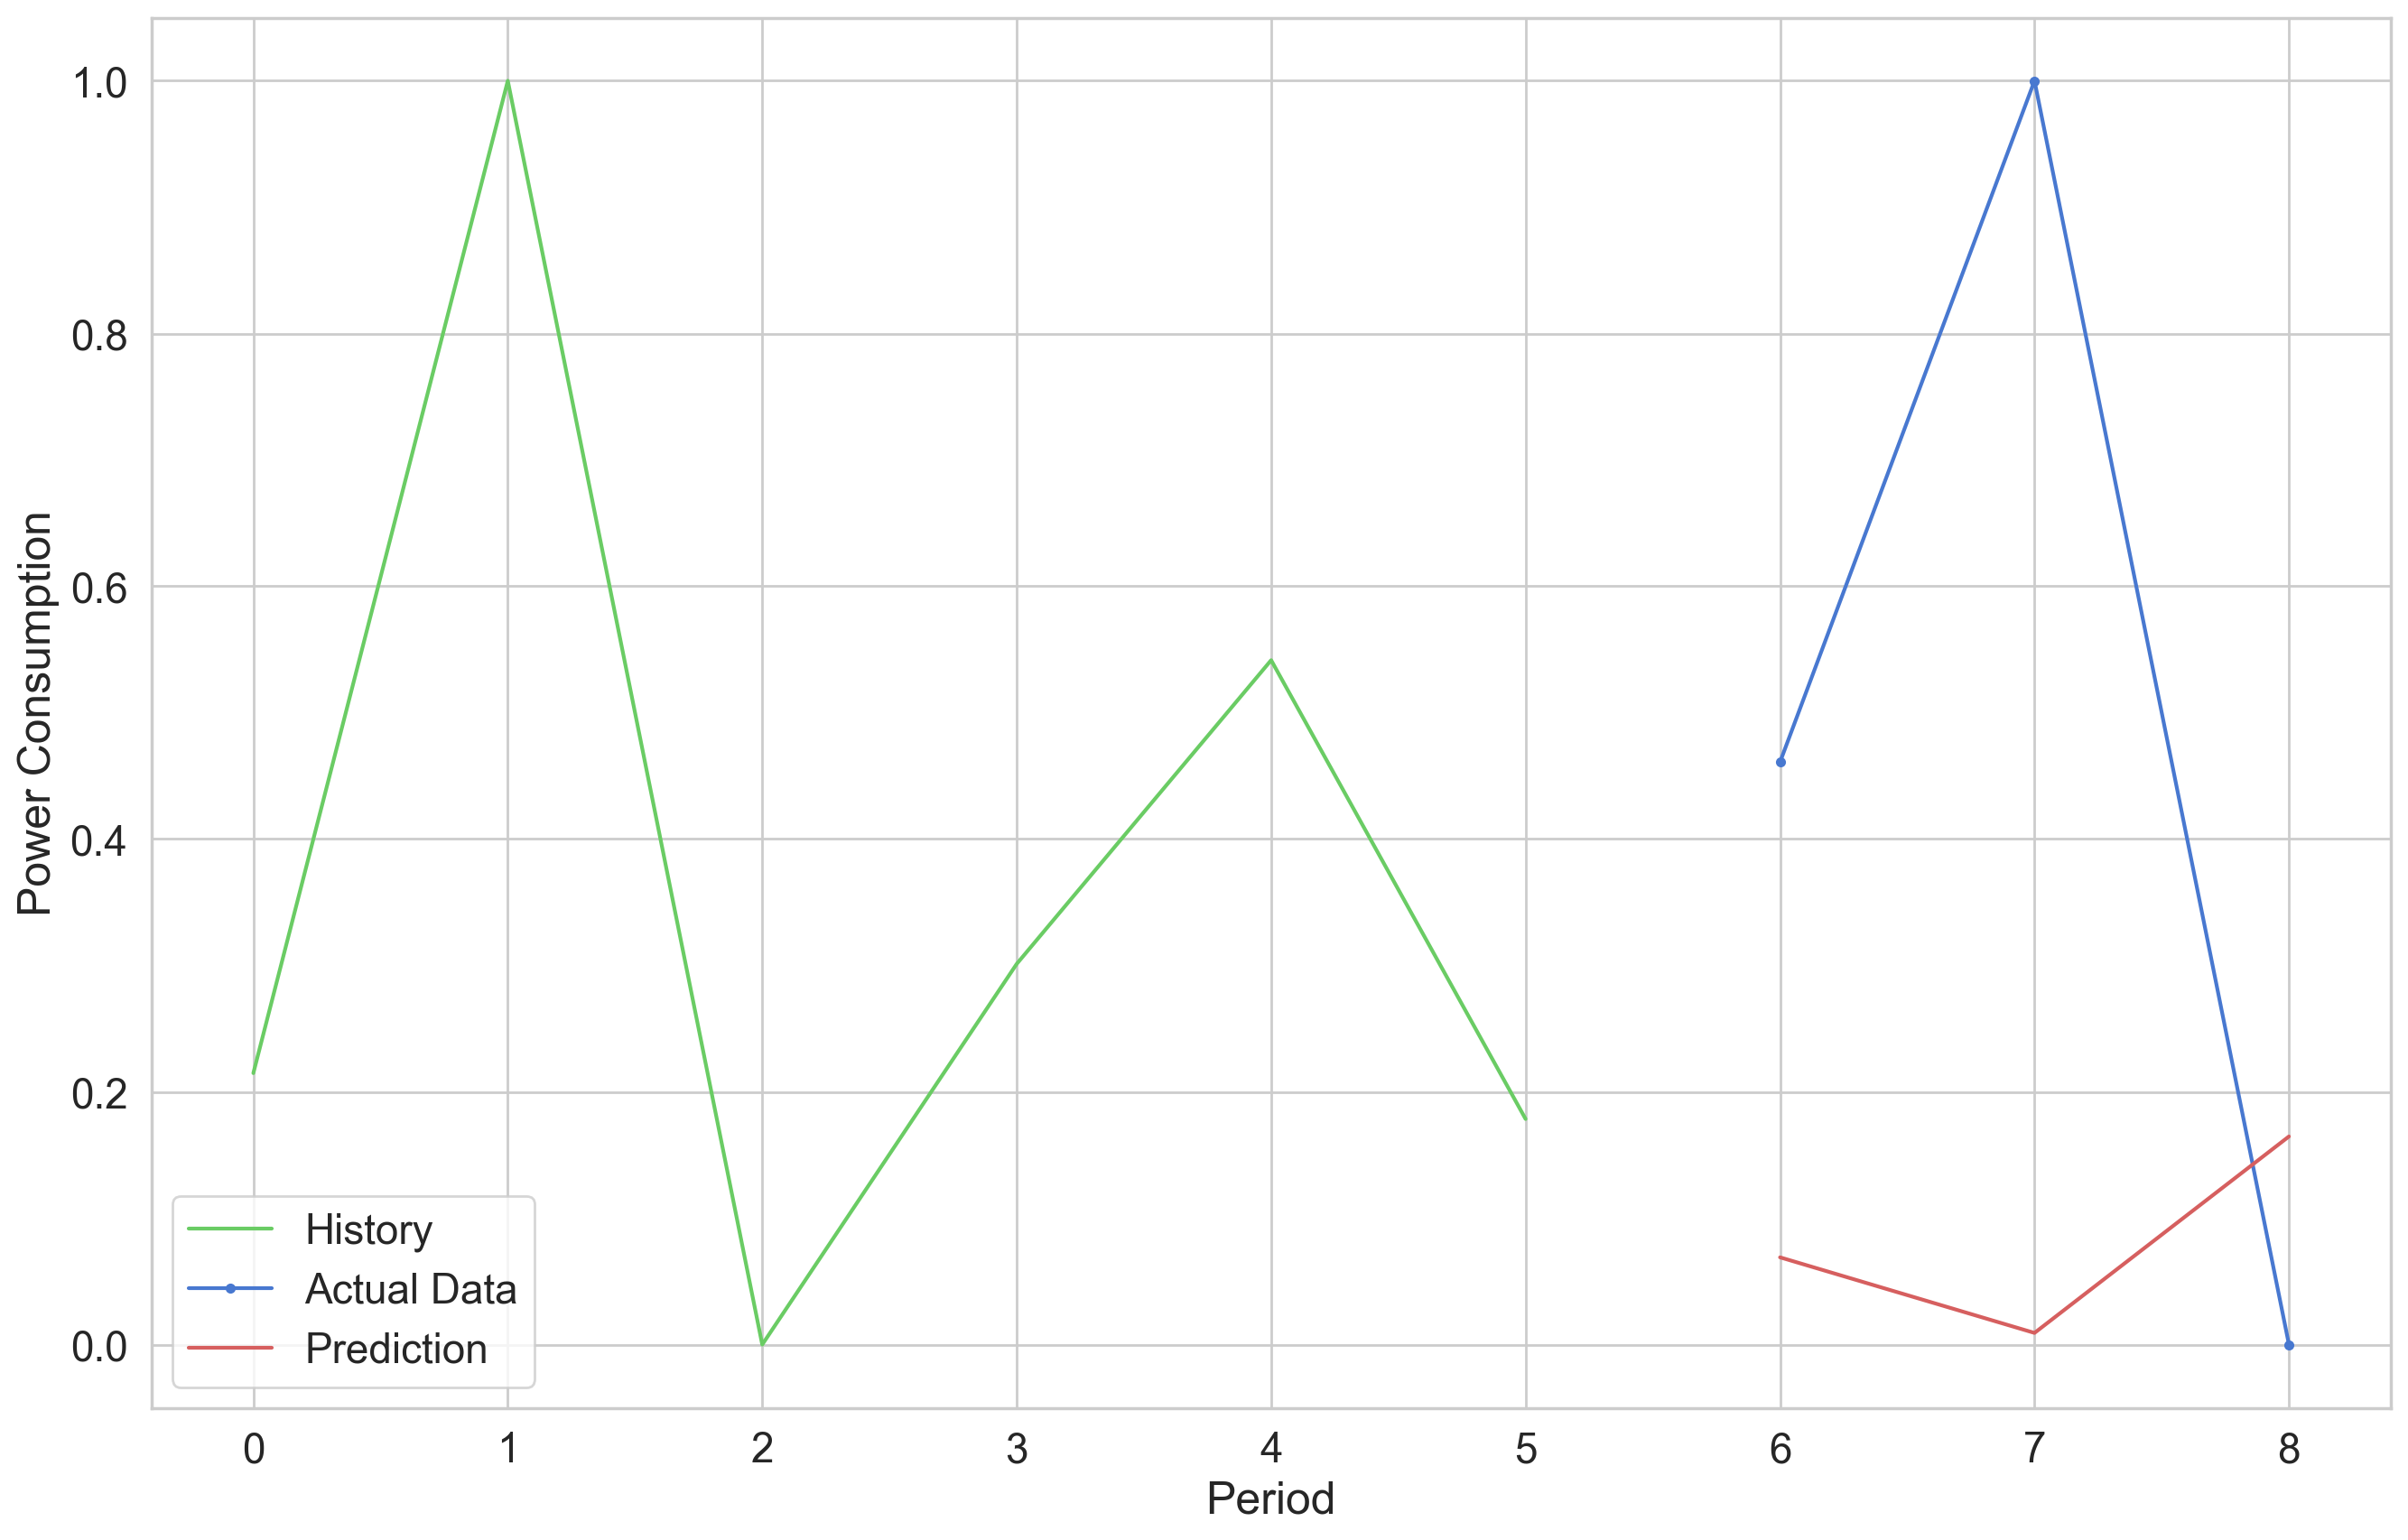

In [31]:
plt.plot(np.arange(0, len(y_train_s_mon)), y_train_s_mon, 'g', label="History")
plt.plot(np.arange(len(y_train_s_mon), len(y_train_s_mon) + len(y_test_s_mon)), y_test_s_mon, marker='.', label="Actual Data")
plt.plot(np.arange(len(y_train_s_mon), len(y_train_s_mon) + len(y_test_s_mon)), y_pred_mon, 'r', label="Prediction")
plt.ylabel('Power Consumption')
plt.xlabel('Period')
plt.legend()
plt.show();

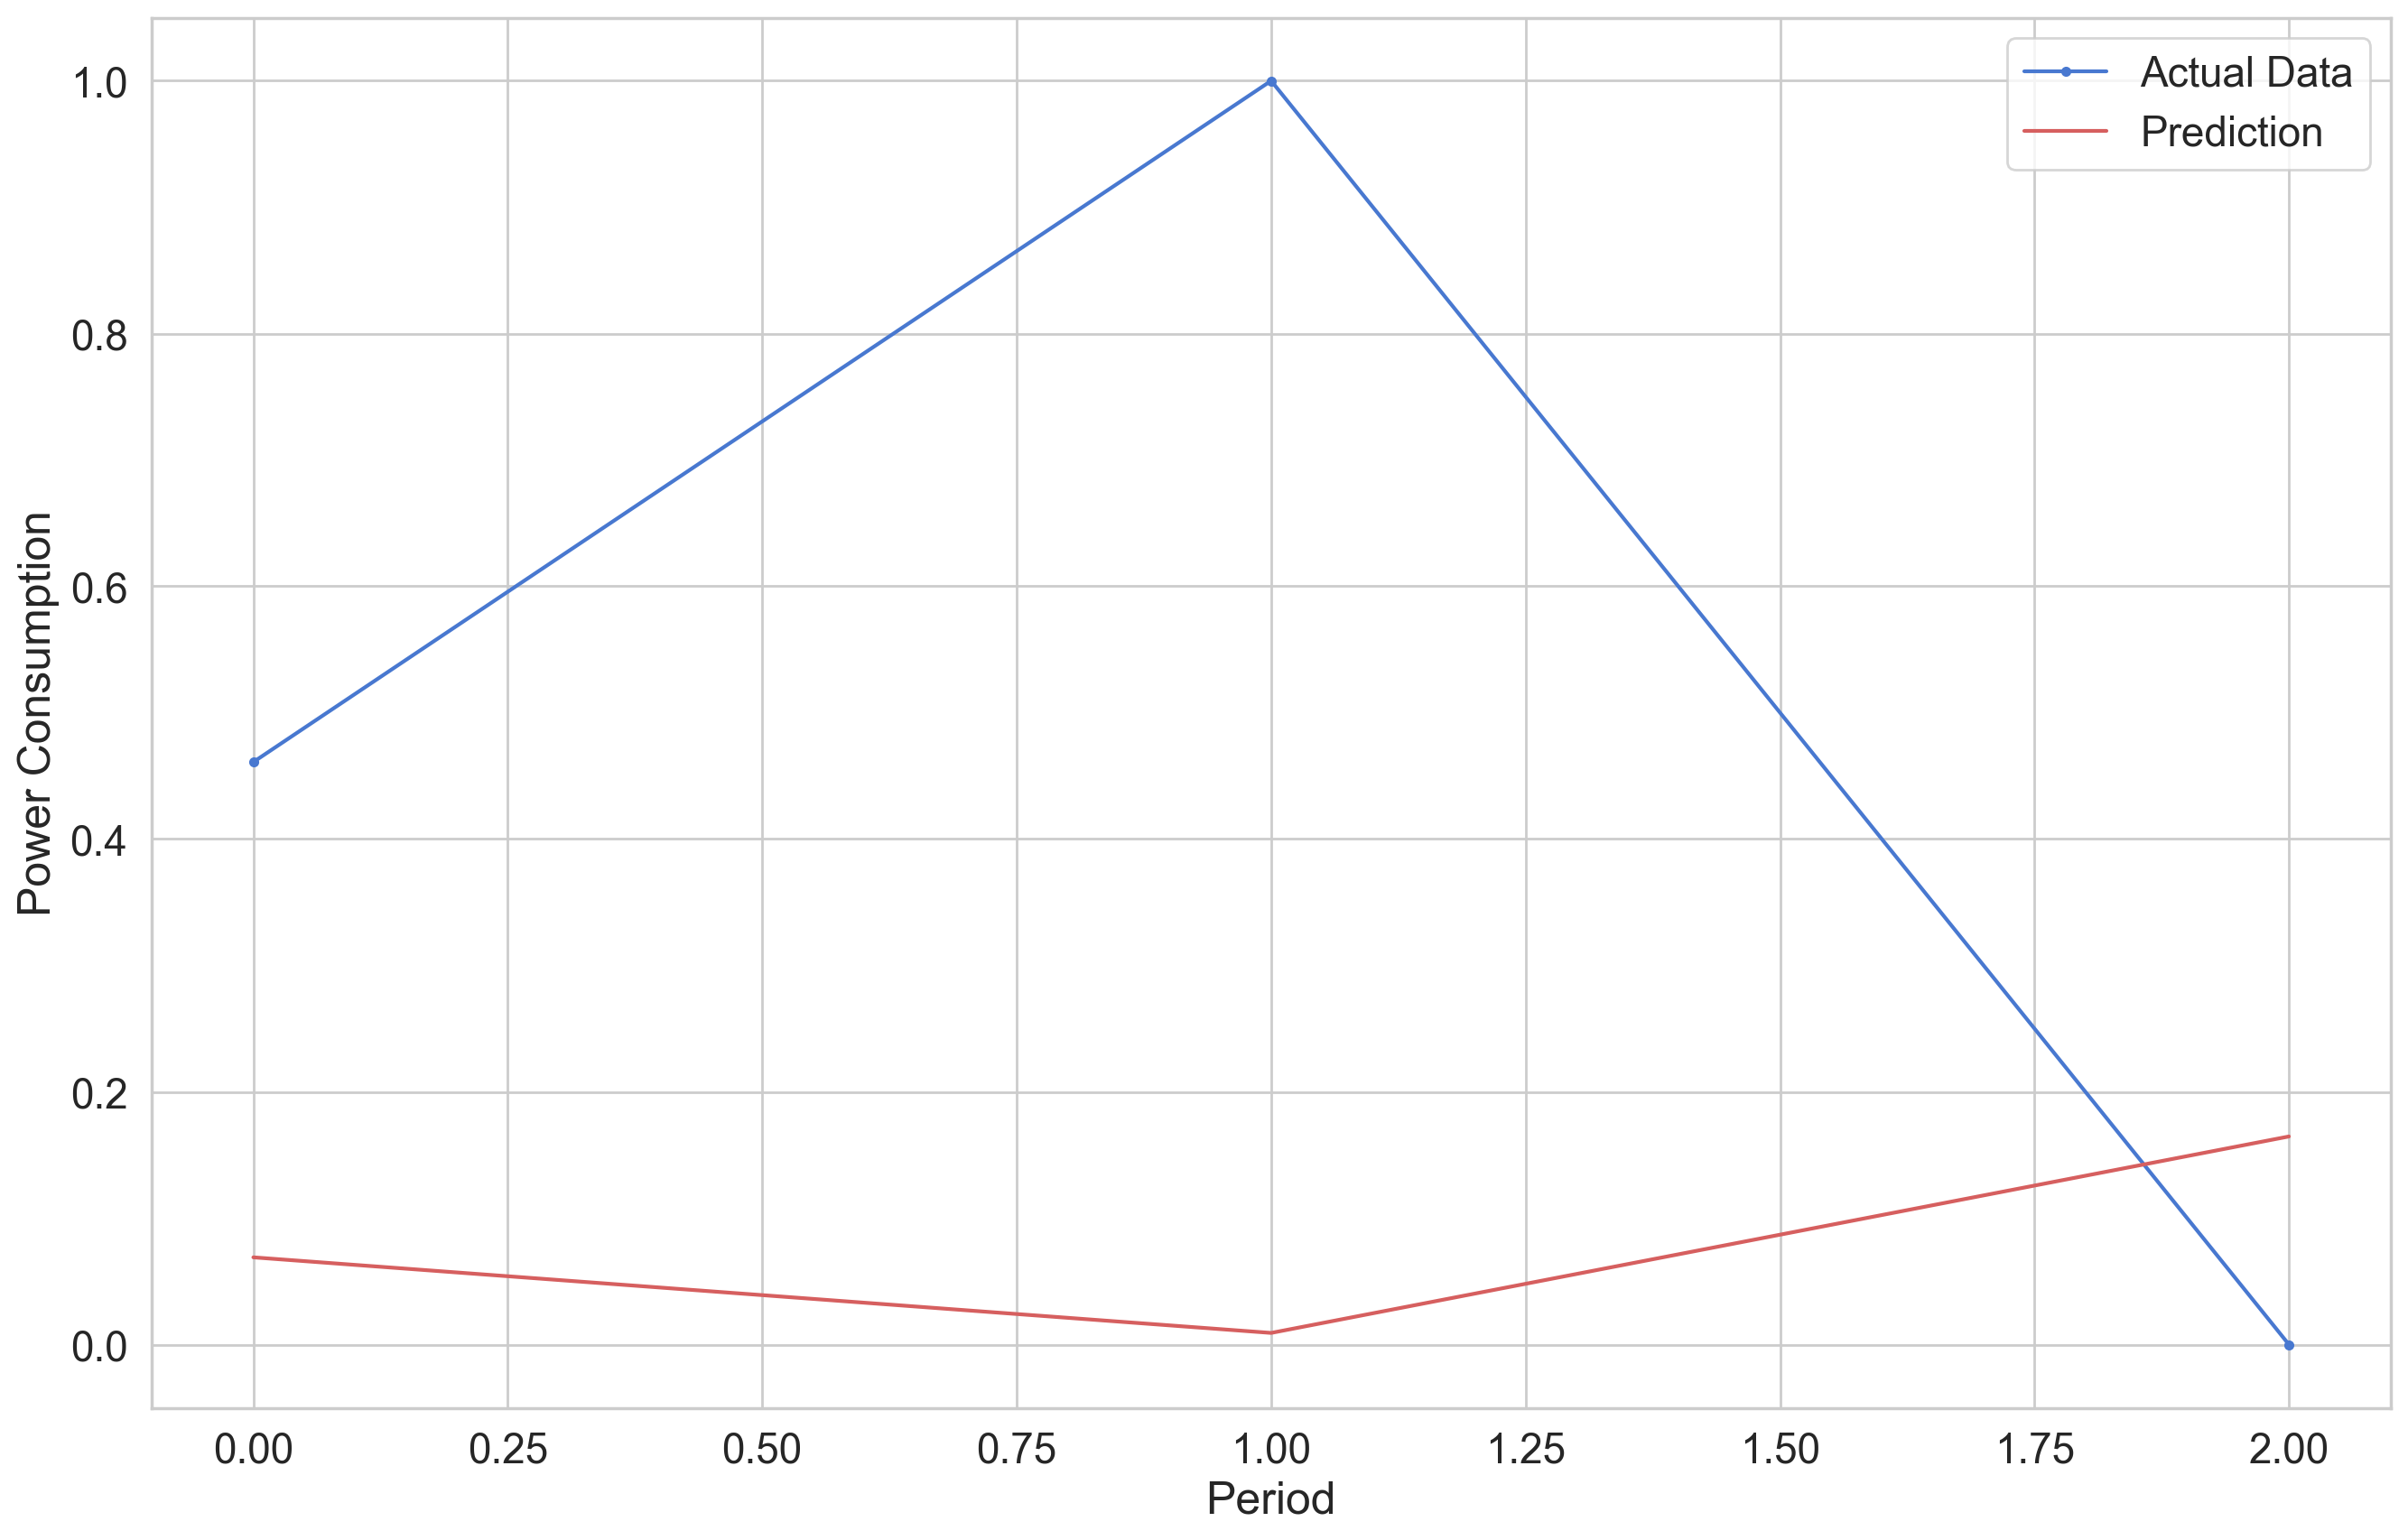

In [32]:
plt.plot(y_test_s_mon, marker='.', label="Actual Data")
plt.plot(y_pred_mon, 'r', label="Prediction")
plt.ylabel('Power Consumption')
plt.xlabel('Period')
plt.legend()
plt.show();

In [33]:
hour=final_df.resample('H').mean() #Hour wise consideration

In [34]:
hour

,lights,acs,plug,Power_consumption
Date,,,,
2018-07-01 00:00:00,0.007368,0.004547,0.003648,0.015562
2018-07-01 01:00:00,0.007397,0.004585,0.003687,0.015669
2018-07-01 02:00:00,0.007378,0.004583,0.003667,0.015628
2018-07-01 03:00:00,0.007312,0.004562,0.003561,0.015435
2018-07-01 04:00:00,0.008315,0.004550,0.003377,0.016241
...,...,...,...,...
2019-12-31 19:00:00,0.006829,0.002392,0.001917,0.011139
2019-12-31 20:00:00,0.006849,0.002853,0.001915,0.011616
2019-12-31 21:00:00,0.005398,0.002273,0.001975,0.009646


In [35]:
hour=np.array(hour)

In [36]:
X_hour,y_hour=to_supervised(hour,n_input=lags,n_out=n_step)

In [37]:
from sklearn.model_selection import train_test_split
X_train0_hour, X_test_hour, y_train0_hour, y_test_hour = train_test_split(X_hour, y_hour, random_state=42)
X_train1_hour, X_validation_hour, y_train1_hour, y_validation_hour = train_test_split(X_train0_hour, y_train0_hour, random_state=42)

In [38]:
X_train_s_hour=scaler.fit_transform(X_train1_hour)
X_validation_s_hour=scaler.fit_transform(X_validation_hour)
X_test_s_hour=scaler.fit_transform(X_test_hour)
y_train_s_hour=scaler.fit_transform(y_train1_hour)
y_validation_s_hour=scaler.fit_transform(y_validation_hour)
y_test_s_hour=scaler.fit_transform(y_test_hour)

In [39]:
model_hour=Sequential()
model_hour.add(Dense(10,activation="relu",input_dim=X_train_s_hour.shape[1]))
model_hour.add(Dense(20,activation="relu"))
model_hour.add(Dense(30,activation="relu"))
model_hour.add(Dense(n_step,activation="selu"))
model_hour.compile(loss='mse',optimizer="adam")

In [40]:
history_mlp_hour=model_hour.fit(X_train_s_hour,y_train_s_hour,epochs=40, validation_data=(X_validation_s_hour,y_validation_s_hour), batch_size=32,verbose=1,shuffle=False)

Epoch 1/40
232/232 [==============================] - 2s 3ms/step - loss: 0.0117 - val_loss: 0.0067
Epoch 2/40
232/232 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0057
Epoch 3/40
232/232 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0056
Epoch 4/40
232/232 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0055
Epoch 5/40
232/232 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0055
Epoch 6/40
232/232 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0054
Epoch 7/40
232/232 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0053
Epoch 8/40
232/232 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0052
Epoch 9/40
232/232 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0052
Epoch 10/40
232/232 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0051

In [41]:
y_pred_hour = model_hour.predict(X_test_s_hour)

103/103 [==============================] - 0s 1ms/step


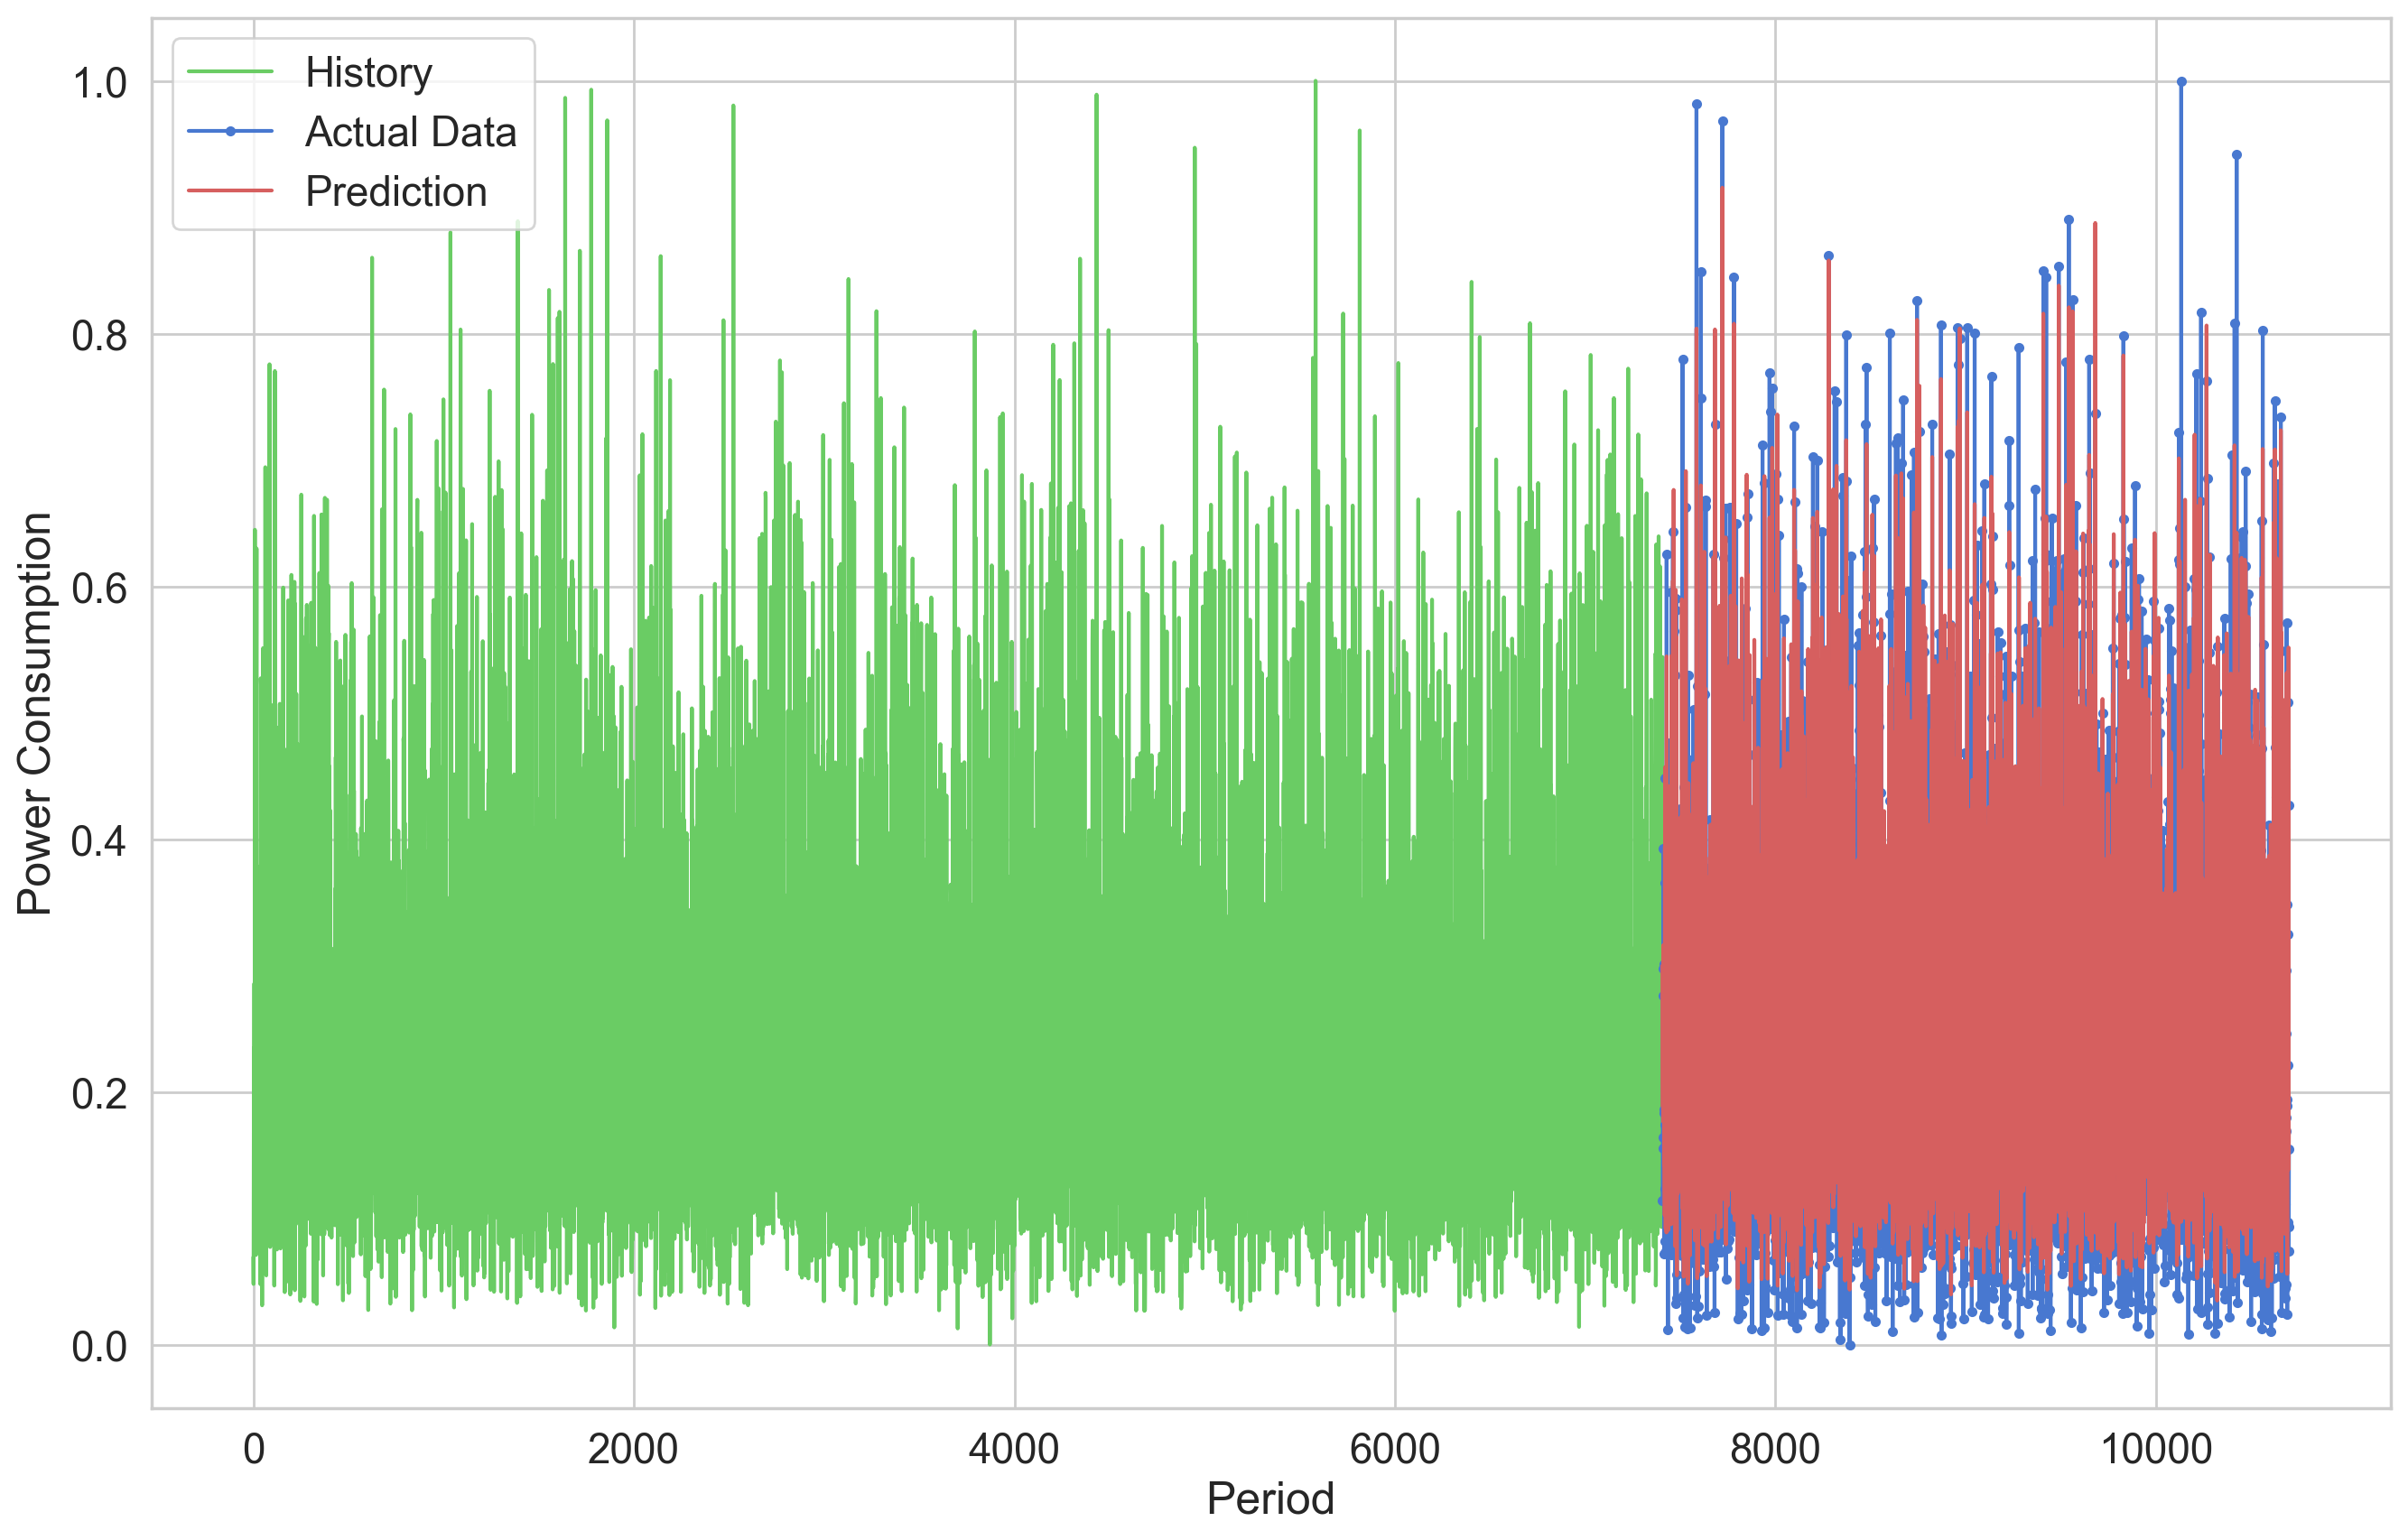

In [42]:
plt.plot(np.arange(0, len(y_train_s_hour)), y_train_s_hour, 'g', label="History")
plt.plot(np.arange(len(y_train_s_hour), len(y_train_s_hour) + len(y_test_s_hour)), y_test_s_hour, marker='.', label="Actual Data")
plt.plot(np.arange(len(y_train_s_hour), len(y_train_s_hour) + len(y_test_s_hour)), y_pred_hour, 'r', label="Prediction")
plt.ylabel('Power Consumption')
plt.xlabel('Period')
plt.legend()
plt.show();

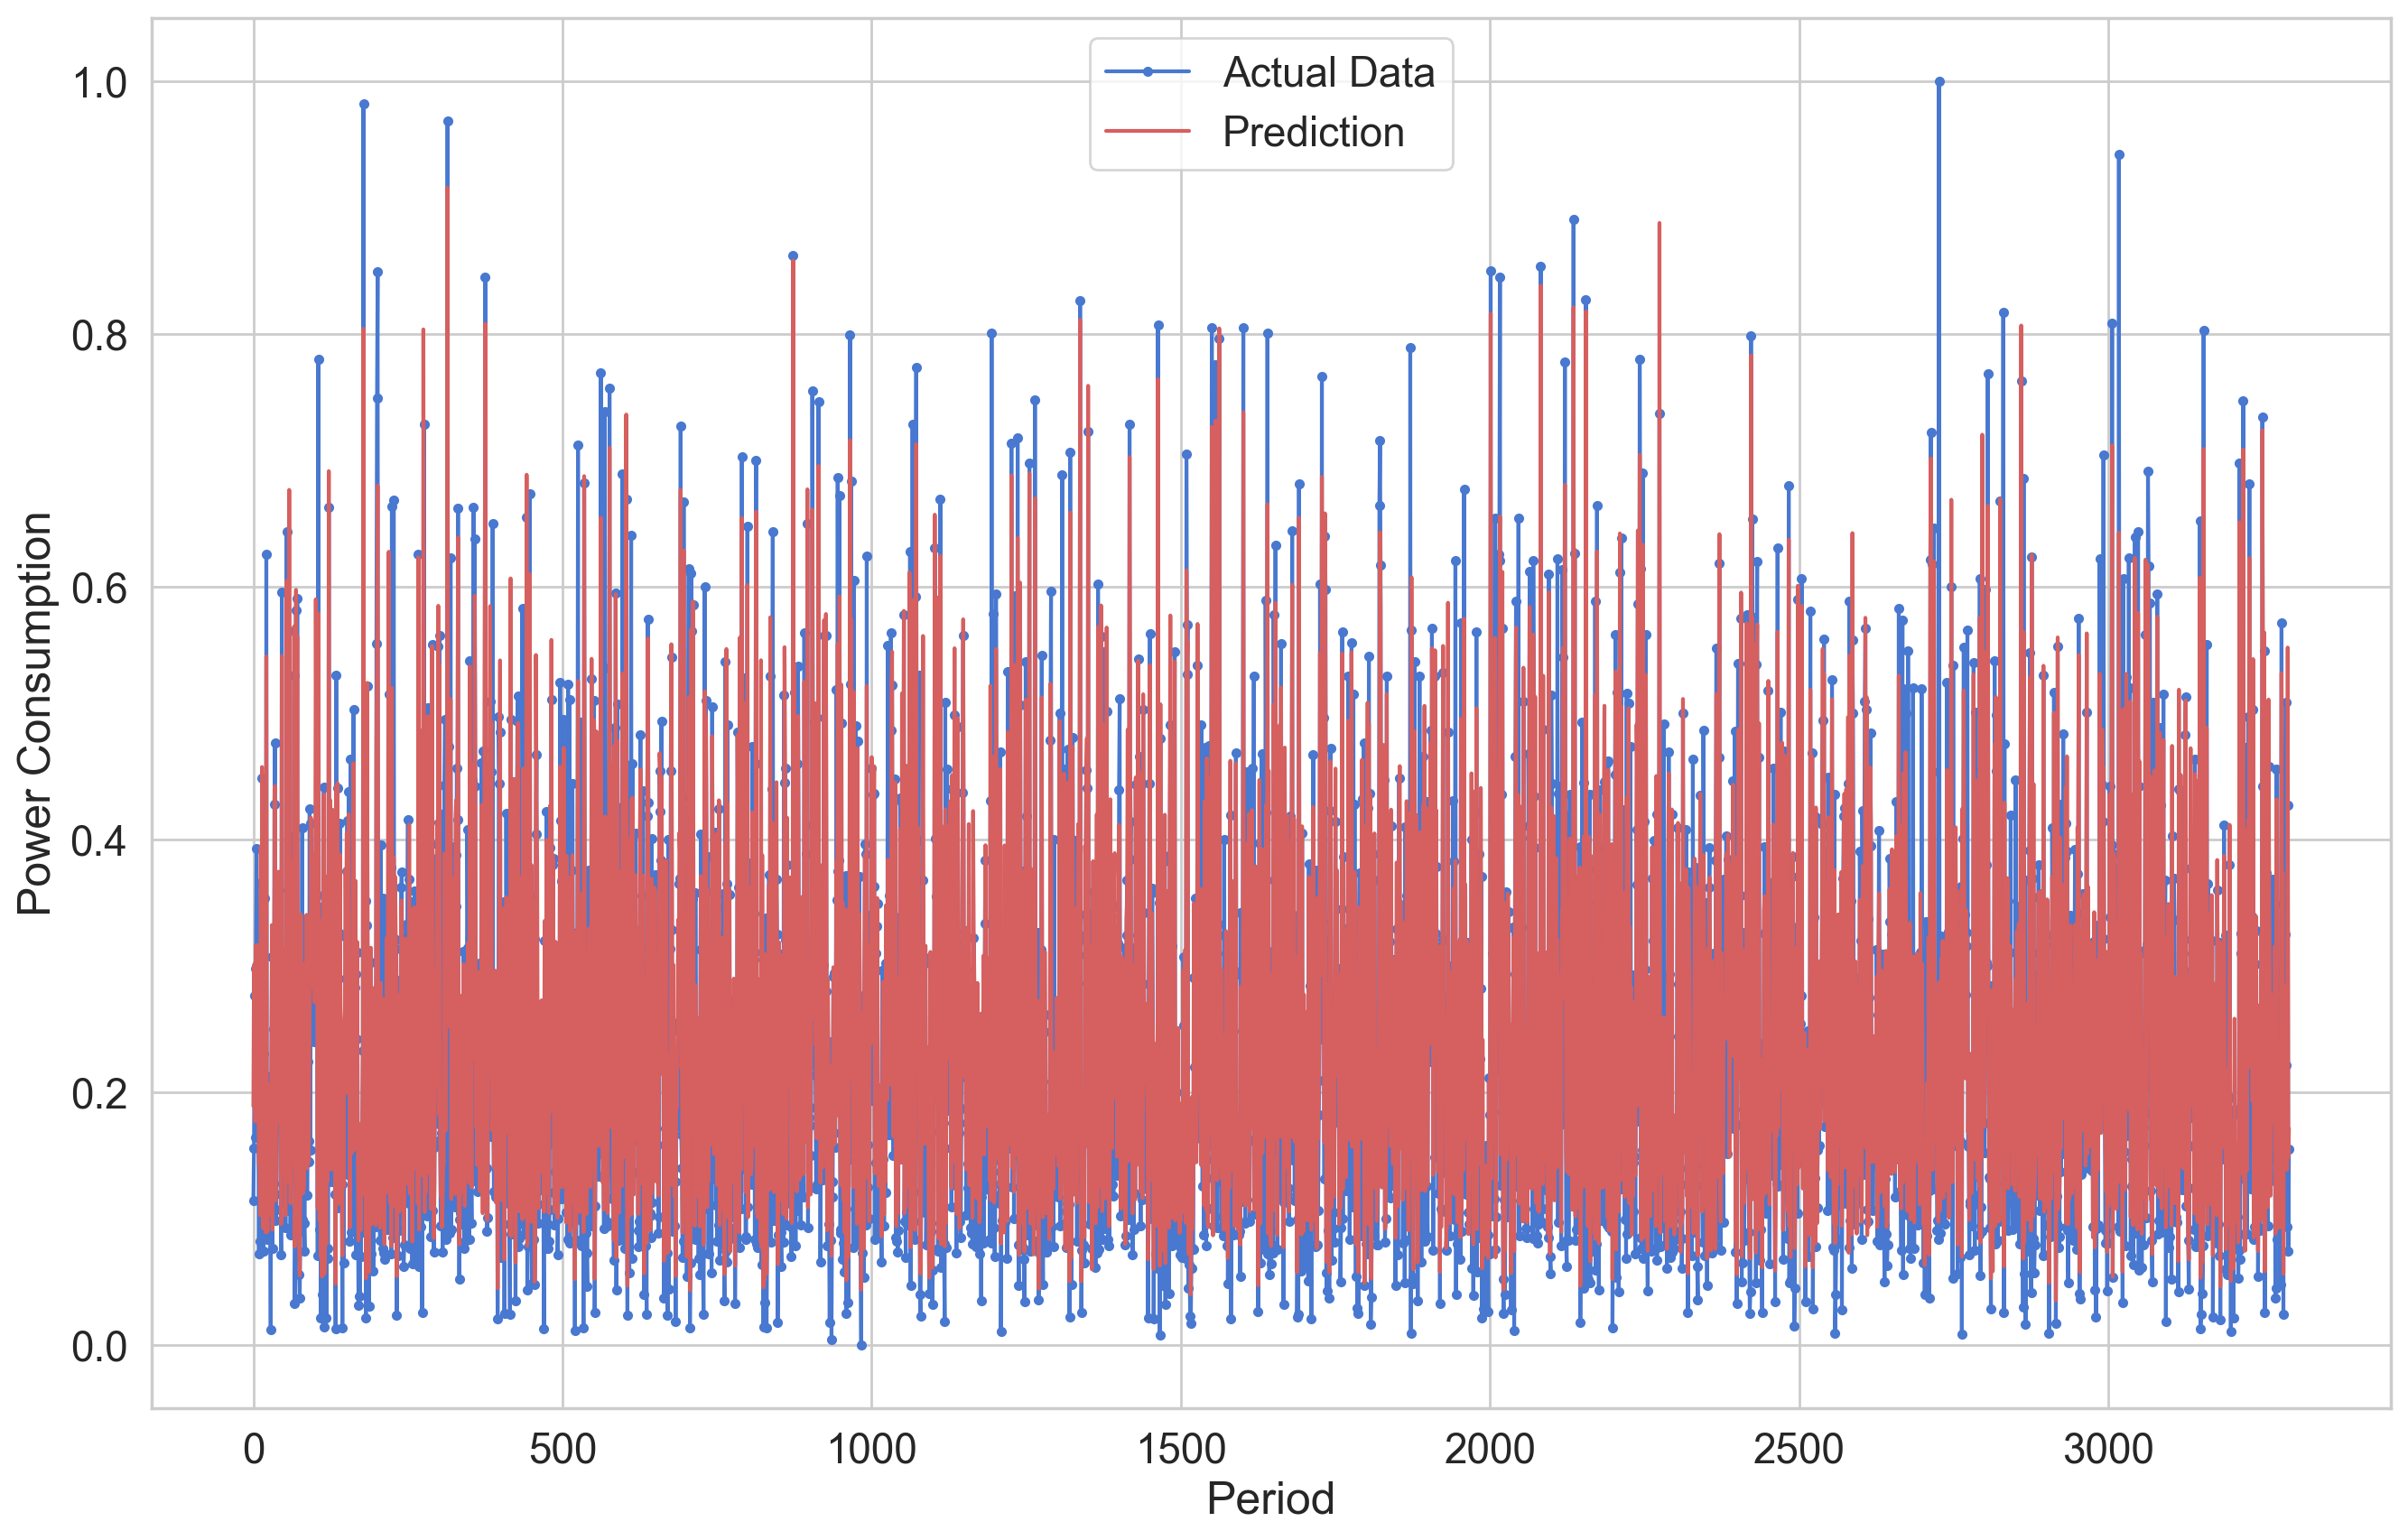

In [43]:
plt.plot(y_test_s_hour, marker='.', label="Actual Data")
plt.plot(y_pred_hour, 'r', label="Prediction")
plt.ylabel('Power Consumption')
plt.xlabel('Period')
plt.legend()
plt.show();

In [44]:
day=final_df.resample('D').mean() #Day wise consideration

In [45]:
day

,lights,acs,plug,Power_consumption
Date,,,,
2018-07-01,0.006271,0.004690,0.002867,0.013829
2018-07-02,0.006457,0.005545,0.003120,0.015123
2018-07-03,0.006940,0.002389,0.002701,0.012031
2018-07-04,0.006437,0.002904,0.002929,0.012271
2018-07-05,0.005636,0.003608,0.002430,0.011676
...,...,...,...,...
2019-12-27,0.005553,0.002822,0.001711,0.010086
2019-12-28,0.004423,0.005230,0.001950,0.011604
2019-12-29,0.004315,0.003900,0.001796,0.010011


In [46]:
day=np.array(day)

In [47]:
X_day,y_day=to_supervised(day,n_input=lags,n_out=n_step)

In [48]:
from sklearn.model_selection import train_test_split
X_train0_day, X_test_day, y_train0_day, y_test_day = train_test_split(X_day, y_day, random_state=42)
X_train1_day, X_validation_day, y_train1_day, y_validation_day = train_test_split(X_train0_day, y_train0_day, random_state=42)

In [49]:
X_train_s_day=scaler.fit_transform(X_train1_day)
X_validation_s_day=scaler.fit_transform(X_validation_day)
X_test_s_day=scaler.fit_transform(X_test_day)
y_train_s_day=scaler.fit_transform(y_train1_day)
y_validation_s_day=scaler.fit_transform(y_validation_day)
y_test_s_day=scaler.fit_transform(y_test_day)

In [50]:
model_day=Sequential()
model_day.add(Dense(10,activation="relu",input_dim=X_train_s_day.shape[1]))
model_day.add(Dense(20,activation="relu"))
model_day.add(Dense(30,activation="relu"))
model_day.add(Dense(n_step,activation="selu"))
model_day.compile(loss='mse',optimizer="adam")

In [51]:
history_mlp_day=model_day.fit(X_train_s_day,y_train_s_day,epochs=40, validation_data=(X_validation_s_day,y_validation_s_day), batch_size=64,verbose=1,shuffle=False)

Epoch 1/40


5/5 [==============================] - 1s 45ms/step - loss: 0.1458 - val_loss: 0.2030
Epoch 2/40
5/5 [==============================] - 0s 11ms/step - loss: 0.0986 - val_loss: 0.1518
Epoch 3/40
5/5 [==============================] - 0s 15ms/step - loss: 0.0716 - val_loss: 0.1154
Epoch 4/40
5/5 [==============================] - 0s 14ms/step - loss: 0.0526 - val_loss: 0.0869
Epoch 5/40
5/5 [==============================] - 0s 10ms/step - loss: 0.0386 - val_loss: 0.0648
Epoch 6/40
5/5 [==============================] - 0s 9ms/step - loss: 0.0292 - val_loss: 0.0490
Epoch 7/40
5/5 [==============================] - 0s 12ms/step - loss: 0.0238 - val_loss: 0.0392
Epoch 8/40
5/5 [==============================] - 0s 9ms/step - loss: 0.0218 - val_loss: 0.0341
Epoch 9/40
5/5 [==============================] - 0s 11ms/step - loss: 0.0217 - val_loss: 0.0321
Epoch 10/40
5/5 [==============================] - 0s 11ms/step - loss: 0.0215 - val_loss: 0.0316
Epoch 11/40
5/5 [=========================

In [52]:
y_pred_day = model_day.predict(X_test_s_day)

5/5 [==============================] - 0s 2ms/step


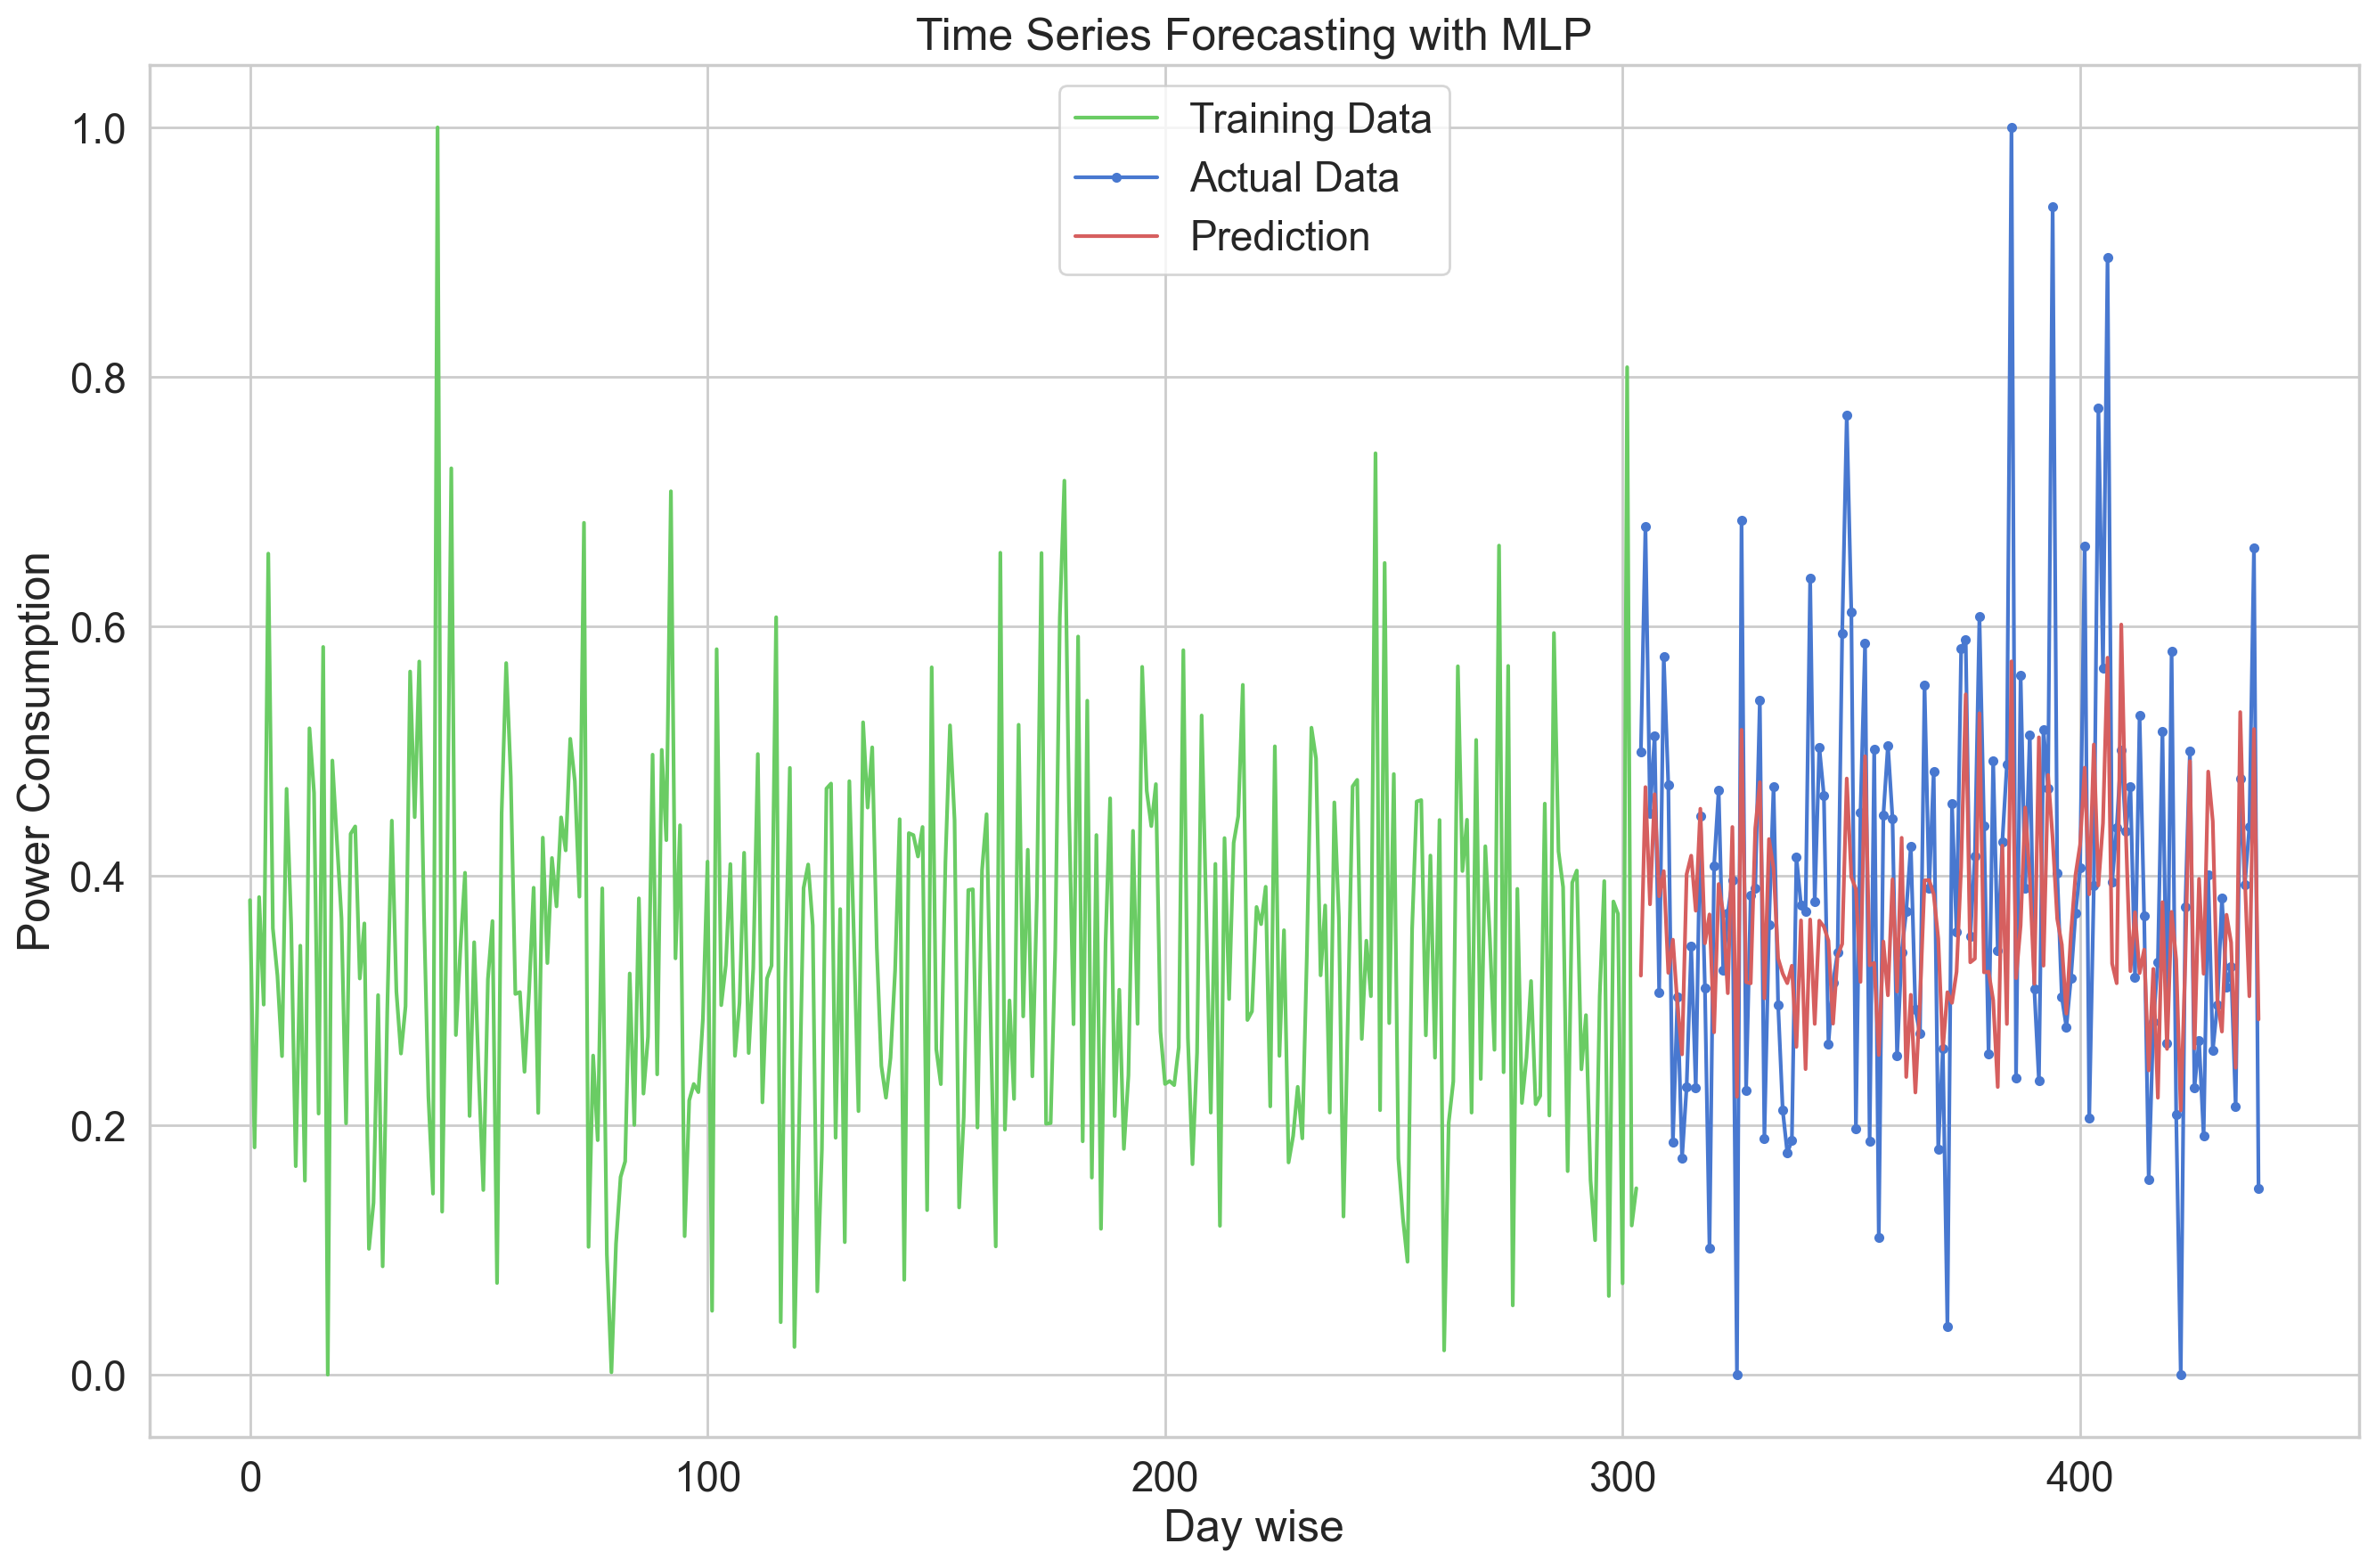

In [53]:
plt.plot(np.arange(0, len(y_train_s_day)), y_train_s_day, 'g', label="Training Data")
plt.plot(np.arange(len(y_train_s_day), len(y_train_s_day) + len(y_test_s_day)), y_test_s_day, marker='.', label="Actual Data")
plt.plot(np.arange(len(y_train_s_day), len(y_train_s_day) + len(y_test_s_day)), y_pred_day, 'r', label="Prediction")
plt.legend(loc='best')
plt.title('Time Series Forecasting with MLP')
plt.ylabel('Power Consumption')
plt.xlabel('Day wise')
plt.legend()
plt.show();

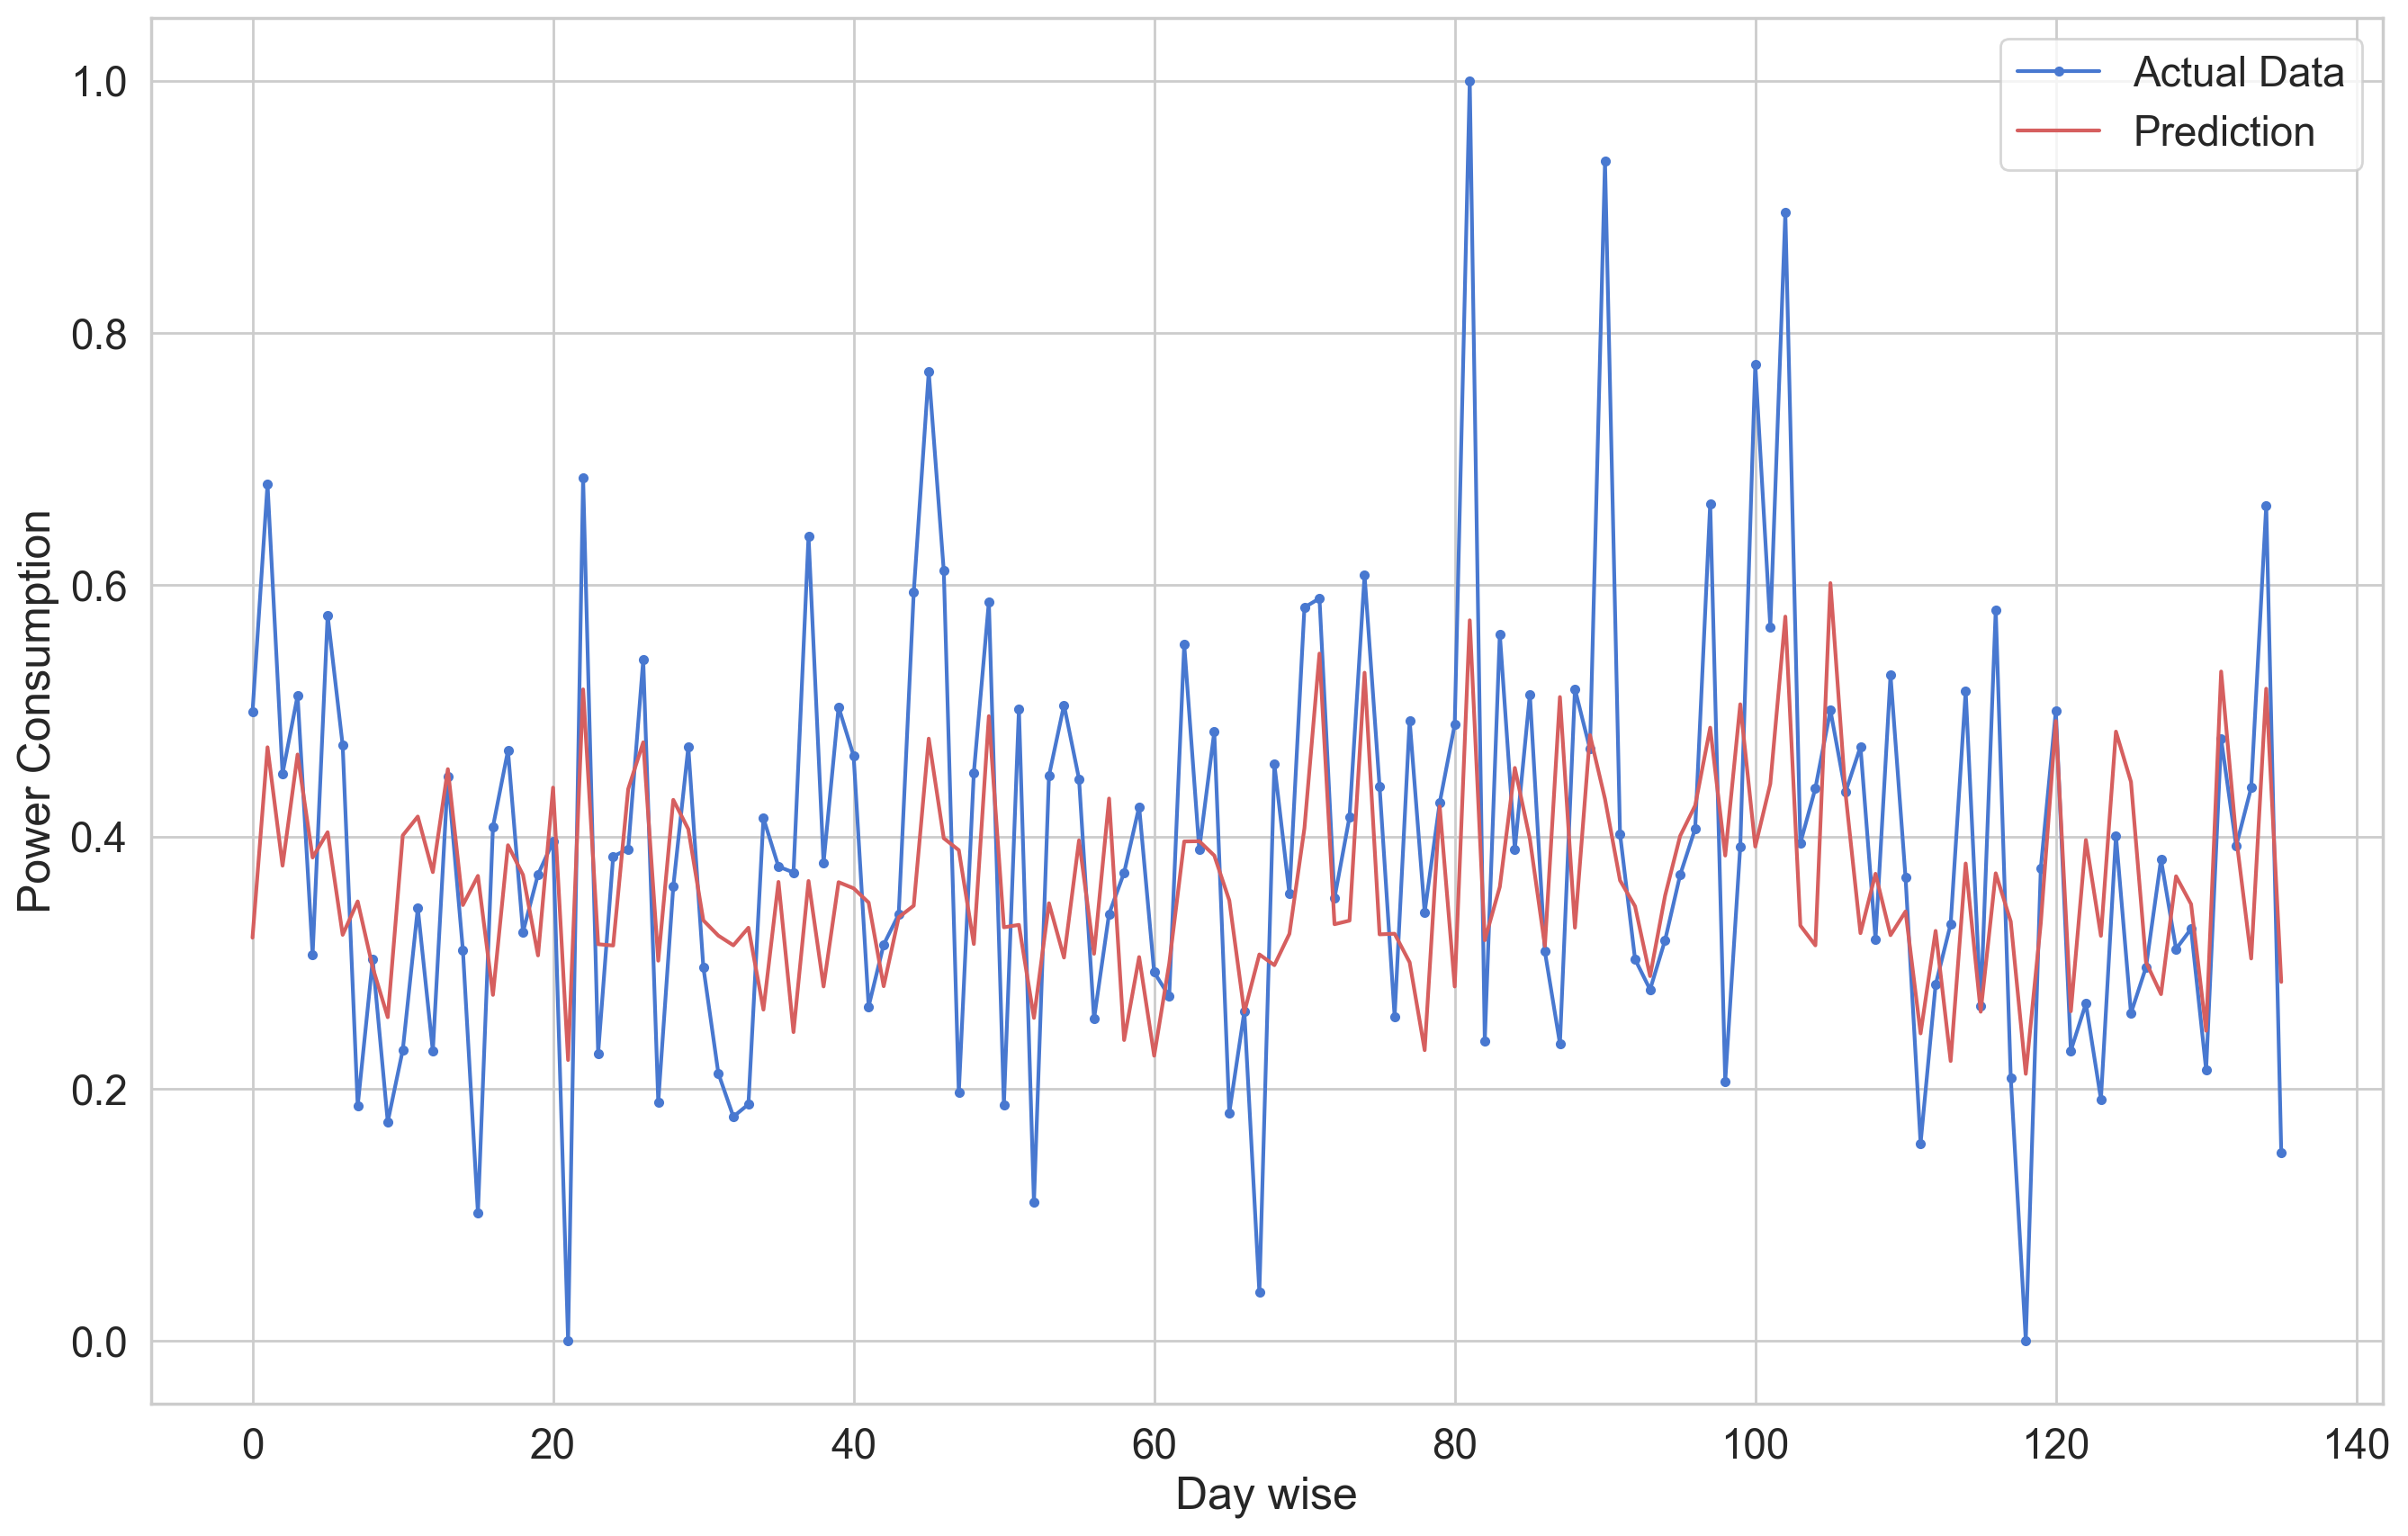

In [54]:
plt.plot(y_test_s_day, marker='.', label="Actual Data")
plt.plot(y_pred_day, 'r', label="Prediction")
plt.ylabel('Power Consumption')
plt.xlabel('Day wise')
plt.legend()
plt.show();